In [1]:
file_path = "/kaggle/input/corpus-1m/corpus_1m.txt"

with open(file_path, 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

print("🧾 Tổng số câu:", len(lines))

🧾 Tổng số câu: 1000000


In [2]:
for i in range(5):
    print(f"{i+1}: {lines[i]}")

1: Chây ì nộp phạt nguội.
2: Hàng chục ngàn phương tiện bị ghi hình vi phạm luật giao thông ở TP.HCM, bị 'bêu tên' nhưng chủ vẫn không chịu nộp phạt.
3: Trên cổng thông tin điện tử của Công an TP.HCM (CATP), mục thông tin về phương tiện vi phạm hành chính qua hình ảnh (từ ngày 4.1.2017 - 4.1.2018), có ghi nhận biển số xe, lỗi vi phạm, ngày vi phạm của 34.118 phương tiện (ô tô) chưa nộp phạt.
4: Đây là các phương tiện vi phạm được camera (di động hoặc cố định) của CATP ghi hình phạt nguội .
5: Điều đáng nói, dù Phòng CSGT đường bộ - đường sắt (PC67), CATP nhiều lần gửi giấy thông báo vi phạm về công an địa phương nhưng chủ hoặc người điều khiển phương tiện vẫn chưa thực hiện quyết định xử phạt hành chính.


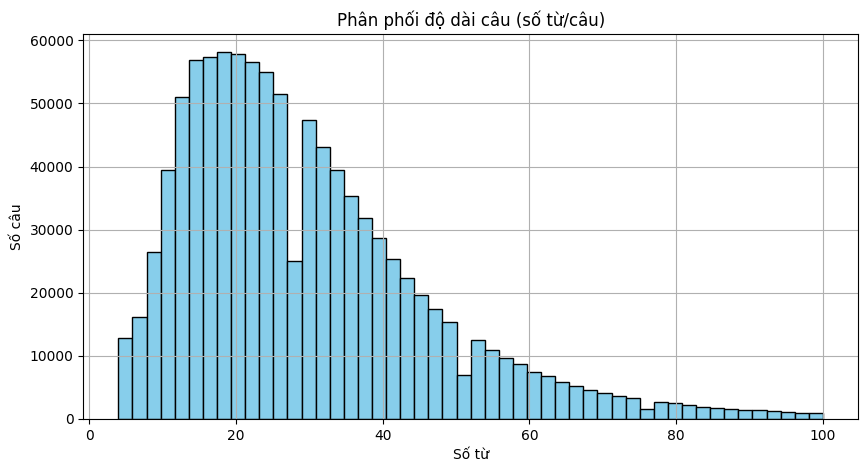

📊 Độ dài câu trung bình: 29.449166
🪜 Độ dài lớn nhất: 100
🪜 Độ dài nhỏ nhất: 4


In [3]:
sentence_lengths = [len(line.split()) for line in lines]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Phân phối độ dài câu (số từ/câu)")
plt.xlabel("Số từ")
plt.ylabel("Số câu")
plt.grid(True)
plt.show()

print("📊 Độ dài câu trung bình:", sum(sentence_lengths)/len(sentence_lengths))
print("🪜 Độ dài lớn nhất:", max(sentence_lengths))
print("🪜 Độ dài nhỏ nhất:", min(sentence_lengths))

In [4]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.3 MB/s eta 0:00:00


In [5]:
!pip install regex

In [6]:
import json
import regex as re
import numpy as np
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize
import string
import os
import random
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
class CombinedNoiseGenerator:
    def __init__(self, fusion_table_data):
        self.fusion_table = fusion_table_data
        
        self.letters = list("abcdefghijklmnopqrstuvwxyzáàảãạâấầẩẫậăắằẳẵặóòỏõọôốồổỗộơớờởỡợéèẻẽẹêếềểễệúùủũụưứừửữựíìỉĩịýỳỷỹỵđABCDEFGHIJKLMNOPQRSTUVWXYZÁÀẢÃẠÂẤẦẨẪẬĂẮẰẲẴẶÓÒỎÕỌÔỐỒỔỖỘƠỚỜỠỢÉÈẺẼẸÊẾỀỂỄỆÚÙỦŨỤƯứừửữựÍÌỈĨỊÝỲỶỸỴĐ")
        self.letters2 = list("abcdefghijklmnopqrstuvwxyz")
        self.typo_spcls = {"ă":"aw","â":"aa","á":"as","à":"af","ả":"ar","ã":"ax","ạ":"aj","ắ":"aws","ổ":"oor","ỗ":"oox","ộ":"ooj","ơ":"ow",
                           "ằ":"awf","ẳ":"awr","ẵ":"awx","ặ":"awj","ó":"os","ò":"of","ỏ":"or","õ":"ox","ọ":"oj","ô":"oo","ố":"oos","ồ":"oof",
                           "ớ":"ows","ờ":"owf","ở":"owr","ỡ":"owx","ợ":"owj","é":"es","è":"ef","ẻ":"er","ẽ":"ex","ẹ":"ej","ê":"ee","ế":"ees","ề":"eef",
                           "ể":"eer","ễ":"eex","ệ":"eej","ú":"us","ù":"uf","ủ":"ur","ũ":"ux","ụ":"uj","ư":"uw","ứ":"uws","ừ":"uwf","ử":"uwr","ữ":"uwx",
                           "ự":"uwj","í":"is","ì":"if","ỉ":"ir","ị":"ij","ĩ":"ix","ý":"ys","ỳ":"yf","ỷ":"yr","ỵ":"yj","đ":"dd",
                           "Ă":"Aw","Â":"Aa","Á":"As","À":"Af","Ả":"Ar","Ã":"Ax","Ạ":"Aj","Ắ":"Aws","Ổ":"Oor","Ỗ":"Oox","Ộ":"Ooj","Ơ":"Ow",
                           "Ằ":"AWF","Ẳ":"Awr","Ẵ":"Awx","Ặ":"Awj","Ó":"Os","Ò":"Of","Ỏ":"Or","Õ":"Ox","Ọ":"Oj","Ô":"Oo","Ố":"Oos","Ồ":"Oof",
                           "Ớ":"Ows","Ờ":"Owf","Ở":"Owr","Ỡ":"Owx","Ợ":"Owj","É":"Es","È":"Ef","Ẻ":"Er","Ẽ":"Ex","Ẹ":"Ej","Ê":"Ee","Ế":"Ees","Ề":"Eef",
                           "Ể":"Eer","Ễ":"Eex","Ệ":"Eej","Ú":"Us","Ù":"Uf","Ủ":"Ur","Ũ":"Ux","Ụ":"Uj","Ư":"Uw","Ứ":"Uws","ừ":"Uwf","ử":"Uwr","Ữ":"Uwx",
                           "Ự":"Uwj","Í":"Is","Ì":"If","Ỉ":"Ir","Ị":"Ij","Ĩ":"Ix","Ý":"Ys","Ỳ":"Yf","Ỷ":"Yr","Ỵ":"Yj","Đ":"Dd"}
        self.region = {"ẻ":"ẽ","ẽ":"ẻ","ũ":"ủ","ủ":"ũ","ã":"ả","ả":"ã","ỏ":"õ","õ":"ỏ","i":"j"}
        self.region2 = {"s":"x","l":"n","n":"l","x":"s","d":"gi","S":"X","L":"N","N":"L","X":"S","Gi":"D","D":"Gi"}
        self.vowel = list("aeiouyáàảãạâấầẩẫậăắằẳẵặóòỏõọôốồổỗộơớờởỡợéèẻẽẹêếềểễệúùủũụưứừửữựíìỉĩịýỳỷỹỵ")
        self.acronym = {"không":"ko"," anh":" a","em":"e","biết":"bít","giờ":"h","gì":"j","muốn":"mún","học":"hok","yêu":"iu",
                        "chồng":"ck","vợ":"vk"," ông":" ô","được":"đc","tôi":"t",
                        "Không":"Ko"," Anh":" A","Em":"E","Biết":"Bít","Giờ":"H","Gì":"J","Muốn":"Mún","Học":"Hok","Yêu":"Iu",
                        "Chồng":"Ck","Vợ":"Vk"," Ông":" Ô","Được":"Đc","Tôi":"T",}
        self.teen_spcls = {"ch":"ck","ph":"f","th":"tk","nh":"nk",
                           "Ch":"Ck","Ph":"F","Th":"Tk","Nh":"Nk"}

        self.word_couples_hl = [['sương', 'xương'], ['sĩ', 'sỹ'], ['sẽ', 'sẻ'], ['sã', 'sả'], ['sả', 'xả'], ['sẽ', 'sẻ'],
                             ['mùi', 'muồi'], ['chỉnh', 'chỉn'], ['sữa', 'sửa'], ['chuẩn', 'chẩn'], ['lẻ', 'lẽ'], ['chẳng', 'chẵng'],
                             ['cổ', 'cỗ'], ['sát', 'xát'], ['cập', 'cặp'], ['truyện', 'chuyện'], ['xá', 'sá'], ['giả', 'dả'],
                             ['đỡ', 'đở'], ['giữ', 'dữ'], ['giã', 'dã'], ['xảo', 'sảo'], ['kiểm', 'kiễm'], ['cuộc', 'cục'],
                             ['dạng', 'dạn'], ['tản', 'tảng'], ['ngành', 'nghành'], ['nghề', 'ngề'], ['nổ', 'nỗ'], ['rảnh', 'rãnh'],
                             ['sẵn', 'sẳn'], ['sáng', 'xán'], ['xuất', 'suất'], ['suôn', 'suông'], ['sử', 'xử'], ['sắc', 'xắc'],
                             ['chữa', 'chửa'], ['thắn', 'thắng'], ['dỡ', 'dở'], ['trải', 'trãi'], ['trao', 'trau'], ['trung', 'chung'],
                             ['thăm', 'tham'], ['sét', 'xét'], ['dục', 'giục'], ['tả', 'tã'], ['sông', 'xông'], ['sáo', 'xáo'],
                             ['sang', 'xang'], ['ngã', 'ngả'], ['xuống', 'suống'], ['xuồng', 'suồng']]
        self.vn_alphabet = ['a', 'ă', 'â', 'b', 'c', 'd', 'đ', 'e', 'ê', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'ô',
                            'ơ', 'p', 'q', 'r', 's', 't', 'u', 'ư', 'v', 'x', 'y']
        self.alphabet_len = len(self.vn_alphabet)
        self.char_couples_hl = [['i', 'y'], ['s', 'x'], ['gi', 'd'], ['ă', 'â'], ['ch', 'tr'], ['ng', 'n'],
                             ['nh', 'n'], ['ngh', 'ng'], ['ục', 'uộc'], ['o', 'u'], ['ă', 'a'], ['o', 'ô'], ['ả', 'ã'], ['ổ', 'ỗ'], ['ủ', 'ũ'], ['ễ', 'ể'],
                             ['e', 'ê'], ['à', 'ờ'], ['ằ', 'à'], ['ẩn', 'uẩn'], ['ẽ', 'ẻ'], ['ùi', 'uồi'], ['ă', 'â'],
                             ['ở', 'ỡ'], ['ỹ', 'ỷ'], ['ỉ', 'ĩ'], ['ị', 'ỵ'],
                             ['ấ', 'á'], ['n', 'l'], ['qu', 'w'], ['ph', 'f'], ['d', 'z'], ['c', 'k'], ['qu', 'q'],
                             ['i', 'j'], ['gi', 'j']]
        self.teencode_dict_hl = {'mình': ['mk', 'mik', 'mjk'], 'vô': ['zô', 'zo', 'vo'], 'vậy': ['zậy', 'z', 'zay', 'za'],
                              'phải': ['fải', 'fai', ], 'biết': ['bit', 'biet'],
                              'rồi': ['rùi', 'ròi', 'r'], 'bây': ['bi', 'bay'], 'giờ': ['h', ],
                              'không': ['k', 'ko', 'khong', 'hk', 'hong', 'hông', '0', 'kg', 'kh', ],
                              'đi': ['di', 'dj', ], 'gì': ['j', ], 'em': ['e', ], 'được': ['dc', 'đc', ], 'tao': ['t'],
                              'tôi': ['t'], 'chồng': ['ck'], 'vợ': ['vk']
                              }
        self.typo_henryle = {"ă": ["aw", "a8"], "â": ["aa", "a6"], "á": ["as", "a1"], "à": ["af", "a2"], "ả": ["ar", "a3"],
                             "ã": ["ax", "a4"], "ạ": ["aj", "a5"], "ắ": ["aws", "ă1"], "ổ": ["oor", "ô3"], "ỗ": ["oox", "Ô4"],
                             "Ộ": ["Ooj", "Ô5"], "Ơ": ["Ow", "O7"],
                             "Ằ": ["AWF", "Ă2"], "Ẳ": ["Awr", "Ă3"], "Ẵ": ["Awx", "Ă4"], "Ặ": ["Awj", "Ă5"], "Ó": ["Os", "O1"],
                             "Ò": ["Of", "O2"], "Ỏ": ["Or", "O3"], "Õ": ["Ox", "O4"], "Ọ": ["Oj", "O5"], "Ô": ["Oo", "O6"],
                             "Ố": ["Oos", "Ô1"], "Ồ": ["Oof", "Ô2"],
                             "Ớ": ["Ows", "Ơ1"], "Ờ": ["Owf", "Ơ2"], "Ở": ["Owr", "Ơ3"], "Ỡ": ["Owx", "Ơ4"], "Ợ": ["Owj", "Ơ5"],
                             "É": ["Es", "E1"], "È": ["Ef", "E2"], "Ẻ": ["Er", "E3"], "Ẽ": ["Ex", "E4"], "Ẹ": ["Ej", "E5"],
                             "Ê": ["Ee", "E6"], "Ế": ["Ees", "Ê1"], "ề": ["Eef", "Ê2"],
                             "Ể": ["Eer", "Ê3"], "Ễ": ["Eex", "Ê4"], "Ệ": ["Eej", "Ê5"], "Ú":"Us","Ù":"Uf","Ủ":"Ur","Ũ":"Ux","Ụ":"Uj","Ư":"Uw","Ứ":"Uws","ừ":"Uwf","ử":"Uwr","Ữ":"Uwx",
                           "Ự":"Uwj","Í":"Is","Ì":"If","Ỉ":"Ir","Ị":"Ij","Ĩ":"Ix","Ý":"Ys","Ỳ":"Yf","Ỷ":"Yr","Ỵ":"Yj","Đ":"Dd"}
        
        self.all_word_candidates_hl = self._get_all_word_candidates_hl(self.word_couples_hl)
        self.all_char_candidates_hl = self._get_all_char_candidates_hl(self.char_couples_hl)
        self.keyboardNeighbors = self._getKeyboardNeighbors()

        self.proper_noun_exceptions = {
            "Việt Nam", "Hà Nội", "Hồ Chí Minh", "TPHCM", "Sài Gòn", "Thứ Hai", "Thứ Ba", "Thứ Tư", "Thứ Năm", 
            "Thứ Sáu", "Thứ Bảy", "Chủ Nhật", "Tháng Một", "Tháng Hai", "Tháng Ba", "Tháng Tư", "Tháng Năm", 
            "Tháng Sáu", "Tháng Bảy", "Tháng Tám", "Tháng Chín", "Tháng Mười", "Tháng Mười Một", "Tháng Mười Hai"
        }
        self.proper_noun_exceptions_lower = {name.lower() for name in self.proper_noun_exceptions}

    # --- Helper methods from henryle97/add_noise.py ---
    def _get_all_word_candidates_hl(self, word_couples):
        all_word_candidates = []
        for couple in word_couples:
            all_word_candidates.extend(couple)
        return all_word_candidates

    def _get_all_char_candidates_hl(self, char_couples):
        all_char_candidates = []
        for couple in char_couples:
            all_char_candidates.extend(couple)
        return all_char_candidates

    def _getKeyboardNeighbors(self):
        return {
            'a': "aáàảãạăắằẳẵặâấầẩẫậ", 'ă': "aáàảãạăắằẳẵặâấầẩẫậ", 'â': "aáàảãạăắằẳẵặâấầẩẫậ", 'á': "aáàảãạăắằẳẵặâấầẩẫậ",
            'à': "aáàảãăắằẳẵâấầẩẫ", 'ả': "aảã", 'ã': "aáàảãạăắằẳẵặâấầẩẫậ", 'ạ': "aáàảãạăắằẳẵặâấầẩẫậ",
            'ắ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ằ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ẳ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ặ': "aáàảãạăắằẳẵặâấầẩẫậ",
            'ẵ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ấ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ầ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ẩ': "aáàảãạăắằẳẵặâấầẩẫậ",
            'ẫ': "aáàảãạăắằẳẵặâấầẩẫậ", 'ậ': "aáàảãạăắằẳẵặâấầẩẫậ", 'b': "bh", 'c': "cgn", 'd': "đctơở", 'đ': "d",
            'e': "eéèẻẽẹêếềểễệbpg", 'é': "eéèẻẽẹêếềểễệ", 'è': "eéèẻẽẹêếềểễệ", 'ẻ': "eéèẻẽẹêếềểễệ", 'ẽ': "eéèẻẽẹêếềểễệ", 'ẹ': "eéèẻẽẹêếềểễệ",
            'ê': "eéèẻẽẹêếềểễệá", 'ế': "eéèẻẽẹêếềểễệố", 'ề': "eéèẻẽẹêếềểễệ", 'ể': "eéèẻẽẹêếềểễệôốồổỗộ", 'ễ': "eéèẻẽẹêếềểễệ", 'ệ': "eéèẻẽẹêếềểễệ",
            'g': "qgộ", 'h': "h", 'i': "iíìỉĩịat", 'í': "iíìỉĩĩị", 'ì': "iíìỉĩĩị", 'ỉ': "iíìỉĩĩị", 'ĩ': "iíìỉĩĩị", 'ị': "iíìỉĩĩịhự",
            'k': "klh", 'l': "ljidđ", 'm': "mn", 'n': "mnedư",
            'o': "oóòỏọõôốồổỗộơớờởợỡ", 'ó': "oóòỏọõôốồổỗộơớờởợỡ", 'ò': "oóòỏọõôốồổỗộơớờởợỡ", 'ỏ': "oóòỏọõôốồổỗộơớờởợỡ", 'õ': "oóòỏọõôốồổỗộơớờởợỡ", 'ọ': "oóòỏọõôốồổỗộơớờởợỡ",
            'ô': "oóòỏọõôốồổỗộơớờởợỡ", 'ố': "oóòỏọõôốồổỗộơớờởợỡ", 'ồ': "oóòỏọõôốồổỗộơớờởợỡ", 'ổ': "oóòỏọõôốồổỗộơớờởợỡ", 'ộ': "oóòỏọõôốồổỗộơớờởợỡ", 'ỗ': "oóòỏọõôốồổỗộơớờởợỡ",
            'ơ': "oóòỏọõôốồổỗộơớờởợỡ", 'ớ': "oóòỏọõôốồổỗộơớờởợỡ", 'ờ': "oóòỏọõôốồổỗộơớờởợỡà", 'ở': "oóòỏọõôốồổỗộơớờởợỡ", 'ợ': "oóòỏọõôốồổỗộơớờởợỡ", 'ỡ': "oóòỏọõôốồổỗộơớờởợỡ",
            'u': "uúùủũụưứừữửựhiaạt", 'ú': "uúùủũụưứừữửự", 'ù': "uúùủũụưứừữửự", 'ủ': "uúùủũụưứừữửự", 'ũ': "uúùủũụưứừữửự", 'ụ': "uúùủũụưứừữửự",
            'ư': "uúùủũụưứừữửựg", 'ứ': "uúùủũụưứừữửự", 'ừ': "uúùủũụưứừữửự", 'ử': "uúùủũụưứừữửự", 'ữ': "uúùủũụưứừữửự", 'ự': "uúùủũụưứừữửựg",
            'v': "v", 'x': "x", 'y': "yýỳỷỵỹụ", 'ý': "yýỳỷỵỹ", 'ỳ': "yýỳỷỵỹ", 'ỷ': "yýỳỷỵỹ", 'ỵ': "yýỳỷỵỹ", 'ỹ': "yýỳỷỵỹ",
        }

    def _replace_teencode_henryle(self, word):
        candidates = self.teencode_dict_hl.get(word, None)
        if candidates is not None:
            chosen_one = 0
            if len(candidates) > 1:
                chosen_one = np.random.randint(0, len(candidates))
            return candidates[chosen_one]
        return word

    def _replace_word_candidate_henryle(self, word):
        capital_flag = word and word[0].isupper()
        word_lower = word.lower()
        if capital_flag and word_lower in self.teencode_dict_hl:
            return self._replace_teencode_henryle(word_lower).capitalize()
        elif word_lower in self.teencode_dict_hl:
            return self._replace_teencode_henryle(word_lower)

        for couple in self.word_couples_hl:
            for i in range(2):
                if couple[i] == word_lower:
                    if i == 0:
                        return couple[1].capitalize() if capital_flag else couple[1]
                    else:
                        return couple[0].capitalize() if capital_flag else couple[0]
        return word

    def _replace_char_candidate_henryle(self, char):
        for couple in self.char_couples_hl:
            for i in range(2):
                if couple[i] == char:
                    return couple[1] if i == 0 else couple[0]
        return char

    def _replace_char_candidate_typo_henryle(self, char):
        if char in self.typo_henryle and len(self.typo_henryle[char]) > 0:
            return random.choice(self.typo_henryle[char])
        return char

    def _remove_diacritics_henryle(self, word):
        from unidecode import unidecode
        if word == unidecode(word):
            return word
        return unidecode(word)

    def _replace_char_noaccent_henryle(self, word):
        if not word: return word
        if not self.keyboardNeighbors: return word
        
        modifiable_char_indices = [idx for idx, char in enumerate(word) if char in self.keyboardNeighbors and len(self.keyboardNeighbors[char]) > 0]
        
        if not modifiable_char_indices: return word
        
        idx_char = random.choice(modifiable_char_indices)
        char = word[idx_char]
        
        replaced = random.choice(list(self.keyboardNeighbors[char]))
        return word[:idx_char] + replaced + word[idx_char+1:]

    def _replace_random_letter_henryle(self, word):
        if not word: return word
        if not self.vn_alphabet: return word
        
        if len(word) > 0:
            idx_char = np.random.randint(0, len(word))
            replaced = random.choice(self.vn_alphabet)
            return word[:idx_char] + replaced + word[idx_char+1:]
        return word

    def _remove_random_letter_henryle(self, word):
        if not word or len(word) == 1: return "" if len(word) == 1 else word
        if len(word) > 0:
            idx_char = np.random.randint(0, len(word))
            return word[:idx_char] + word[idx_char+1:]
        return word

    def _teen_code_spcls(self, sentence):
        new_sentence = str(sentence)
        random_val = np.random.uniform(0,1,1)[0]
        if random_val > 0.5:
            for word_acronym in self.acronym.keys():
                if re.search(r'\b' + re.escape(word_acronym) + r'\b', new_sentence, re.IGNORECASE):
                    if np.random.uniform(0,1,1)[0] < 0.5:
                        new_sentence = re.sub(r'\b' + re.escape(word_acronym) + r'\b', self.acronym[word_acronym], new_sentence, flags=re.IGNORECASE)
            for word_teen in self.teen_spcls.keys():
                if re.search(r'\b' + re.escape(word_teen) + r'\b', new_sentence, re.IGNORECASE):
                    if np.random.uniform(0,1,1)[0] < 0.05:
                        new_sentence = re.sub(r'\b' + re.escape(word_teen) + r'\b', self.teen_spcls[word_teen], new_sentence, flags=re.IGNORECASE)
        return new_sentence

    def _apply_char_level_typo_spcls(self, char, sentence_chars_list, char_idx):
        """Applies character-level typos from add_noise-Sp-Cls.py"""
        modified_char = char
        if not char.isalpha():
            return modified_char

        random_val = np.random.uniform(0,1,1)[0]
        
        typo_candidates = self.typo_spcls.get(char, [])
        region_candidates = self.region.get(char, None) # region gives single char, not list
        region2_candidates = self.region2.get(char, None) # region2 gives single char, not list

        # Create a list of possible actions based on char presence in dicts
        action_weights = []
        possible_actions = []

        if char in self.typo_spcls and len(self.typo_spcls[char]) > 0 and char in self.region:
            possible_actions.extend(['typo_spcls', 'region', 'unidecode'])
            action_weights.extend([0.4, 0.4, 0.15]) # Sum 0.95, will be normalized
        elif char in self.typo_spcls and len(self.typo_spcls[char]) > 0:
            possible_actions.extend(['typo_spcls', 'unidecode'])
            action_weights.extend([0.6, 0.3]) # Sum 0.9, will be normalized
        elif char in self.region:
            possible_actions.extend(['region', 'unidecode'])
            action_weights.extend([0.6, 0.25]) # Sum 0.85, will be normalized
        
        # Region2 specific logic
        if char_idx < len(sentence_chars_list) - 1:
            next_char = sentence_chars_list[char_idx+1]
            if char in self.region2.keys() and \
               (char_idx == 0 or not sentence_chars_list[char_idx-1].isalpha()) and \
               next_char in self.vowel:
                # If region2 applies, it might override or be added. Given original logic,
                # it's a direct replacement with high prob. Let's make it a separate choice.
                if np.random.uniform(0,1,1)[0] <= 0.9:
                    return self.region2[char] # Direct return if region2 applies strongly

        if not possible_actions: # If no specific typo/region rule applies, just try unidecode if it's a letter
            if char.isalpha():
                 from unidecode import unidecode; return unidecode(char) # Fallback unidecode
            return modified_char # No change if nothing applicable

        # Normalize weights
        sum_weights = sum(action_weights)
        normalized_action_weights = [w / sum_weights for w in action_weights] if sum_weights > 0 else [1.0 / len(possible_actions)] * len(possible_actions)

        chosen_action = random.choice(possible_actions) # FIX: use random.choice directly

        if chosen_action == 'typo_spcls':
            modified_char = random.choice(self.typo_spcls[char])
        elif chosen_action == 'region':
            modified_char = self.region[char]
        elif chosen_action == 'unidecode':
            from unidecode import unidecode; modified_char = unidecode(char)
        
        return modified_char

    def _apply_char_level_structural_spcls(self, word_chars_list):
        """Applies character-level swap, insertion, deletion from add_noise-Sp-Cls.py within a word."""
        if not any(char.isalpha() for char in word_chars_list):
            return word_chars_list

        modified_chars = list(word_chars_list)
        
        alphabetic_indices = [i for i, char in enumerate(modified_chars) if char.isalpha()]
        
        if not alphabetic_indices:
            return word_chars_list

        random_val = np.random.uniform(0,1,1)[0]
        if random_val <= 0.5: # Swap
            if len(alphabetic_indices) >= 2:
                idx_to_swap1, idx_to_swap2 = random.sample(alphabetic_indices, 2)
                modified_chars[idx_to_swap1], modified_chars[idx_to_swap2] = modified_chars[idx_to_swap2], modified_chars[idx_to_swap1]
            else:
                return word_chars_list
        else: # Delete
            if len(alphabetic_indices) > 0: 
                char_idx_to_delete = random.choice(alphabetic_indices)
                del modified_chars[char_idx_to_delete]
            else:
                return word_chars_list
        
        return modified_chars

    def _is_proper_noun_candidate(self, token, token_index, tokens_in_sentence_segments):
        """
        Helper to check if a token is a proper noun candidate based on the defined rules.
        A token is considered a proper noun candidate (and thus immutable) if:
        1. It's not alphanumeric (punctuation, spaces, etc.).
        2. It's purely numeric (digits only).
        3. It matches specific capitalization patterns that suggest it's a proper noun.
        4. It's in the explicit proper_noun_exceptions list.
        """
        # Rule 1 & 2: If not alphabetic OR it's purely digits, treat as unchangeable.
        # This is the primary guard for numbers and punctuation.
        if not token.isalpha() or token.isdigit(): 
            return True

        is_proper_noun = False
        current_word_lower = token.lower()

        # Determine if it's the first alphanumeric word of a sentence (after potential punctuation)
        is_first_word_of_sentence = (token_index == 0)
        if token_index > 0:
            for i in range(token_index - 1, -1, -1):
                prev_segment = tokens_in_sentence_segments[i]
                if prev_segment.isalpha() or prev_segment.isdigit(): # Found a word/number before, so not sentence start
                    is_first_word_of_sentence = False
                    break
                if prev_segment in ['.', '!', '?']: # Found sentence-ending punctuation
                    is_first_word_of_sentence = True
                    break

        # Rule 3: Capitalized, but not start of sentence/after punctuation
        if token and token[0].isupper() and not is_first_word_of_sentence:
            if current_word_lower not in self.teencode_dict_hl and \
               current_word_lower not in self.all_word_candidates_hl:
                is_proper_noun = True

        # Rule 4: Capitalized at start of sentence/after punctuation AND next word is capitalized
        if is_first_word_of_sentence and token and token[0].isupper():
            next_alphanumeric_token = None
            for i in range(token_index + 1, len(tokens_in_sentence_segments)):
                if tokens_in_sentence_segments[i].isalpha() or tokens_in_sentence_segments[i].isdigit():
                    next_alphanumeric_token = tokens_in_sentence_segments[i]
                    break
            
            if next_alphanumeric_token and next_alphanumeric_token[0].isupper():
                is_proper_noun = True

            # Handle multi-word proper nouns like "TP. HCM" (via dot, e.g. 'TP', '.', 'HCM')
            if token.isupper() and (token_index + 1) < len(tokens_in_sentence_segments) and \
               tokens_in_sentence_segments[token_index + 1] == '.':
                if (token_index + 2) < len(tokens_in_sentence_segments):
                    token_after_dot = tokens_in_sentence_segments[token_index + 2]
                    if token_after_dot and (token_after_dot.isalpha() or token_after_dot.isdigit()) and token_after_dot[0].isupper():
                        is_proper_noun = True

        # Rule 5: Explicit proper noun exceptions
        if current_word_lower in self.proper_noun_exceptions_lower:
            is_proper_noun = True
        
        return is_proper_noun


    def _apply_error_to_syllable(self, original_syllable, token_index, tokens_in_sentence_segments, attempts=5):
        """
        Applies one random error type to an original syllable (which is an alphanumeric segment).
        Attempts to generate a different syllable for 'attempts' times.
        Returns a list containing the modified syllable (or original if no change/error).
        """
        
        # Guards: If not alphabetic or is a proper noun, return unchanged.
        # This is the primary filter for numbers, punctuation, and proper nouns.
        if not original_syllable or not original_syllable.isalpha() or self._is_proper_noun_candidate(original_syllable, token_index, tokens_in_sentence_segments): 
            return [original_syllable]

        error_type_choices = [
            "VSEC_REPLACE", 
            "HENRYLE_HOMOPHONE_WORD", 
            "HENRYLE_HOMOPHONE_CHAR", 
            "HENRYLE_TYPO_CHAR", 
            "HENRYLE_RANDOM_CHAR_OP", 
            "HENRYLE_DIACRITICS_REMOVE",
            "SPCLS_CHAR_TYPO", 
            "SPCLS_CHAR_STRUCTURAL"
        ]
        
        error_probabilities = [
            0.25, # VSEC_REPLACE
            0.20, # HENRYLE_HOMOPHONE_WORD
            0.15, # HENRYLE_HOMOPHONE_CHAR
            0.15, # HENRYLE_TYPO_CHAR
            0.05, # HENRYLE_RANDOM_CHAR_OP
            0.05, # HENRYLE_DIACRITICS_REMOVE
            0.10, # SPCLS_CHAR_TYPO
            0.05  # SPCLS_CHAR_STRUCTURAL
        ]

        sum_probs = sum(error_probabilities)
        if sum_probs == 0:
            return [original_syllable]
        normalized_probabilities = [p / sum_probs for p in error_probabilities]

        for _ in range(attempts):
            if not error_type_choices: # If no error types are defined/chosen
                break
            chosen_error_type = np.random.choice(error_type_choices, p=normalized_probabilities)
            
            modified_syllables_list = [original_syllable]

            if chosen_error_type == "VSEC_REPLACE":
                candidates = self.fusion_table.get(original_syllable, None)
                if candidates is None: 
                    candidates = self.fusion_table.get(original_syllable.lower(), None)
                    if candidates and original_syllable and original_syllable[0].isupper():
                        candidates = [c.capitalize() if c else c for c in candidates]
                
                if candidates and len(candidates) > 0:
                    modified_syllables_list = [random.choice(candidates)] 
                else: 
                    continue

            elif chosen_error_type == "HENRYLE_HOMOPHONE_WORD":
                modified_word = self._replace_word_candidate_henryle(original_syllable)
                if modified_word != original_syllable:
                    modified_syllables_list = [modified_word]
                else:
                    continue

            elif chosen_error_type == "HENRYLE_HOMOPHONE_CHAR":
                modified_word_chars = list(original_syllable)
                if len(modified_word_chars) > 0:
                    possible_char_indices = [i for i, char in enumerate(modified_word_chars) if any(char in couple for couple in self.char_couples_hl)]
                    if not possible_char_indices: continue
                    
                    char_idx_to_modify = random.choice(possible_char_indices)
                    original_char = modified_word_chars[char_idx_to_modify]

                    modified_char = self._replace_char_candidate_henryle(original_char)
                    if modified_char != original_char:
                        modified_syllables_list = ["".join(modified_word_chars[:char_idx_to_modify] + [modified_char] + modified_word_chars[char_idx_to_modify+1:])]
                    else:
                        continue
                else:
                    continue

            elif chosen_error_type == "HENRYLE_TYPO_CHAR":
                modified_word_chars = list(original_syllable)
                if len(modified_word_chars) > 0:
                    possible_char_indices = [i for i, char in enumerate(modified_word_chars) if char in self.typo_henryle and len(self.typo_henryle[char]) > 0]
                    if not possible_char_indices: continue
                    
                    char_idx_to_modify = random.choice(possible_char_indices)
                    original_char = modified_word_chars[char_idx_to_modify]

                    modified_char = self._replace_char_candidate_typo_henryle(original_char)
                    if modified_char != original_char:
                        modified_syllables_list = ["".join(modified_word_chars[:char_idx_to_modify] + [modified_char] + modified_word_chars[char_idx_to_modify+1:])]
                    else:
                        continue
                else:
                    continue

            elif chosen_error_type == "HENRYLE_RANDOM_CHAR_OP":
                op_choices = ["replace", "remove"]
                if not original_syllable or not op_choices: continue

                op_choice = random.choice(op_choices)
                
                if op_choice == "replace":
                    if original_syllable:
                        modified_syllable = self._replace_random_letter_henryle(original_syllable)
                        if modified_syllable != original_syllable:
                            modified_syllables_list = [modified_syllable]
                        else:
                            continue
                    else:
                        continue
                elif op_choice == "remove":
                    if original_syllable and len(original_syllable) > 0:
                        modified_syllable = self._remove_random_letter_henryle(original_syllable)
                        if modified_syllable != original_syllable:
                            modified_syllables_list = [modified_syllable]
                        else:
                            continue 
                    else:
                        continue

            elif chosen_error_type == "HENRYLE_DIACRITICS_REMOVE":
                modified_syllable = self._remove_diacritics_henryle(original_syllable)
                if modified_syllable != original_syllable:
                    modified_syllables_list = [modified_syllable]
                else:
                    continue 

            elif chosen_error_type == "SPCLS_CHAR_TYPO":
                temp_chars = list(original_syllable)
                if len(temp_chars) > 0:
                    possible_char_indices = []
                    for i, char_in_word in enumerate(temp_chars):
                        if char_in_word.isalpha() and \
                           (char_in_word in self.typo_spcls or \
                            char_in_word in self.region or \
                            (char_in_word in self.region2 and i < len(temp_chars) - 1 and temp_chars[i+1] in self.vowel)):
                            possible_char_indices.append(i)
                    
                    if not possible_char_indices: continue

                    char_to_noise_idx = random.choice(possible_char_indices)
                    original_char = temp_chars[char_to_noise_idx]
                    
                    modified_char = self._apply_char_level_typo_spcls(original_char, temp_chars, char_to_noise_idx)
                    if modified_char != original_char:
                        temp_chars[char_to_noise_idx] = modified_char
                        modified_syllables_list = ["".join(temp_chars)]
                    else:
                        continue
                else:
                    continue

            elif chosen_error_type == "SPCLS_CHAR_STRUCTURAL":
                original_len = len(original_syllable)
                modified_chars = self._apply_char_level_structural_spcls(list(original_syllable))
                
                if modified_chars:
                    modified_syllable = "".join(modified_chars)
                    if modified_syllable != original_syllable:
                        modified_syllables_list = [modified_syllable]
                    else:
                        continue 
                else: 
                    if original_len == 1:
                        modified_syllables_list = [""]
                    else:
                        continue

            if modified_syllables_list and modified_syllables_list[0] != original_syllable:
                return modified_syllables_list
            
        return [original_syllable]
    
    def _tokenize_into_segments(self, text):
        """
        Custom tokenizer to split text into alphanumeric words and non-alphanumeric segments (punctuation, spaces).
        This preserves original spacing and punctuation.
        Example: "Hello, world!" -> ["Hello", ",", " ", "world", "!"]
        """
        segments = []
        # \p{L} for unicode letters, \p{N} for unicode numbers.
        # \s+ for whitespace.
        # [^\p{L}\p{N}\s]+ for other non-letter, non-number, non-whitespace characters.
        # re.U is for unicode
        pattern = re.compile(r'([\p{L}\p{N}]+|\s+|[^\p{L}\p{N}\s]+)', re.U) 
        matches = pattern.findall(text)
        
        segments = [match for match in matches if match]
        
        return segments


    def normalize_punctuation(self, text):
        """
        Normalizes punctuation in a given text.
        This version focuses on:
        1. Converting common curly/smart quotes and backticks to straight quotes.
        2. Removing excessive whitespace (multiple spaces to single space, strip).
        It explicitly DOES NOT alter the relative position of punctuation to words,
        nor does it add/remove spaces where original text had none,
        beyond simple multiple space collapsing.
        """
        if not text:
            return ""

        text = text.replace('“', '"').replace('”', '"')
        text = text.replace('‘', "'").replace('’', "'")
        text = text.replace('`', "'") 

        text = re.sub(r'\s+', ' ', text).strip()

        return text
    
    def generate_noisy_sentence(self, clean_sentence, syllable_error_probability=0.2, min_errors=0):
        """
        Generates a single noisy sentence from a clean sentence using random probability for each syllable.
        Attempts to ensure a minimum number of errors for non-zero target_error_rate.
        """
        pristine_correct_text_normalized = self.normalize_punctuation(clean_sentence)

        original_segments = self._tokenize_into_segments(pristine_correct_text_normalized)
        if not original_segments:
            return "", pristine_correct_text_normalized

        noisy_segments_list = list(original_segments)
        
        # Identify indices of modifiable "words" (alphabetic segments that are not proper nouns or numbers)
        modifiable_word_indices = [
            i for i, segment in enumerate(original_segments) 
            if segment.isalpha() and not self._is_proper_noun_candidate(segment, i, original_segments)
        ]

        num_words_to_target_for_error = 0
        if syllable_error_probability > 0 and len(modifiable_word_indices) > 0:
            num_words_to_target_for_error = max(min_errors, int(len(modifiable_word_indices) * syllable_error_probability))
            num_words_to_target_for_error = min(num_words_to_target_for_error, len(modifiable_word_indices))
        
        if num_words_to_target_for_error == 0 and min_errors == 0: 
            return pristine_correct_text_normalized, pristine_correct_text_normalized
        elif num_words_to_target_for_error == 0 and min_errors > 0:
            return pristine_correct_text_normalized, pristine_correct_text_normalized


        random.shuffle(modifiable_word_indices)
        indices_to_error = modifiable_word_indices[:num_words_to_target_for_error]
        
        actual_errors_count = 0
        for index in indices_to_error:
            original_word_segment = original_segments[index]
            modified_word_segments = self._apply_error_to_syllable(original_word_segment, index, original_segments, attempts=10) 
            
            if modified_word_segments and modified_word_segments[0] != original_word_segment:
                noisy_segments_list[index] = modified_word_segments[0]
                actual_errors_count += 1

        if actual_errors_count < min_errors and len(modifiable_word_indices) > 0:
            words_to_force_error = [
                idx for idx in modifiable_word_indices 
                if noisy_segments_list[idx] == original_segments[idx] 
            ]
            random.shuffle(words_to_force_error)

            for index in words_to_force_error:
                if actual_errors_count >= min_errors:
                    break
                original_word_segment = original_segments[index]
                modified_word_segments = self._apply_error_to_syllable(original_word_segment, index, original_segments, attempts=20) 
                if modified_word_segments and modified_word_segments[0] != original_word_segment:
                    noisy_segments_list[index] = modified_word_segments[0]
                    actual_errors_count += 1
        
        final_noisy_text = "".join(noisy_segments_list)

        teencodes_applied_text = self._teen_code_spcls(final_noisy_text)

        final_noisy_text_cleaned = self.normalize_punctuation(teencodes_applied_text)
        
        return final_noisy_text_cleaned, pristine_correct_text_normalized

In [8]:
def get_last_checkpoint(checkpoint_path):
    if os.path.exists(checkpoint_path):
        with open(checkpoint_path, 'r') as f:
            try:
                return int(f.read().strip())
            except ValueError:
                return 0
    return 0

def update_checkpoint(checkpoint_path, line_number):
    with open(checkpoint_path, 'w') as f:
        f.write(str(line_number))

if __name__ == "__main__":
    # 1. Load fusion table
    try:
        with open('/kaggle/input/mapfusion/final_adjusted_fusion_table_map.json', 'r', encoding='utf-8') as f:
            fusion_table_data = json.load(f)
        print("✅ Đã tải fusion table thành công.")
    except FileNotFoundError:
        print("❌ Không tìm thấy typo_dict_vsec.json. Vui lòng đảm bảo file có ở đường dẫn chính xác hoặc đã được tải lên dưới dạng dataset.")
        raise

    # 2. Khởi tạo noise generator
    noise_generator = CombinedNoiseGenerator(fusion_table_data)

    # 3. File paths
    input_file_path = "/kaggle/input/corpus-1m/corpus_1m.txt"
    output_file_path_jsonl = "/kaggle/working/Corpus_text.jsonl"
    checkpoint_file_path = "/kaggle/working/checkpoint.txt"

    print(f"📥 Input: {input_file_path}")
    print(f"📤 Output: {output_file_path_jsonl}")
    print(f"📌 Checkpoint: {checkpoint_file_path}")

    # 4. Resume from last checkpoint
    start_line = get_last_checkpoint(checkpoint_file_path)
    print(f"⏩ Bắt đầu xử lý từ dòng số {start_line}")

    processed_lines_count = 0
    current_line_index = 0
    
    def get_sentence_error_configs(num_words):
        """
        Determines error generation configurations based on sentence length (number of alphabetic words).
        """
        if num_words <= 10:
            # Câu ngắn => giữ 1 bản sạch + lỗi nhẹ
            return [
                (0.00, 0),  # clean
                (0.05, 1),  # ~5% word error rate, min 1 error
                (0.10, 1),  # ~10% word error rate, min 1 error
                (0.15, 2),  # ~15% word error rate, min 2 errors
                (0.20, 2)   # ~20% word error rate, min 2 errors
            ]
        elif num_words <= 20:
            # Câu trung bình => tất cả các bản đều có lỗi, tăng dần độ khó
            return [
                (0.10, 1),
                (0.15, 2),
                (0.20, 3),
                (0.25, 3),
                (0.30, 4)
            ]
        elif num_words <= 30:
            # Câu dài => tất cả các bản đều có lỗi, tăng độ khó rõ rệt
            return [
                (0.15, 2),
                (0.20, 3),
                (0.25, 4),
                (0.30, 5),
                (0.35, 6)
            ]
        else:
            # Câu rất dài => lỗi có thể rất nhiều, độ khó cao nhất
            return [
                (0.20, 3),
                (0.25, 5),
                (0.30, 6),
                (0.35, 7),
                (0.40, 8)
            ]

    with open(input_file_path, 'r', encoding='utf-8') as infile, \
         open(output_file_path_jsonl, 'a', encoding='utf-8') as outfile:  

        for line in infile:
            if current_line_index < start_line:
                current_line_index += 1
                continue

            clean_sentence = line.strip()
            if not clean_sentence:
                current_line_index += 1
                continue

            pristine_correct_text_normalized_once = noise_generator.normalize_punctuation(clean_sentence)

            initial_segments = noise_generator._tokenize_into_segments(pristine_correct_text_normalized_once)
            num_alphabetic_words = len([s for s in initial_segments if s.isalpha()]) # Use isalpha() to count words eligible for error

            current_sentence_configs = get_sentence_error_configs(num_alphabetic_words)
            
            for prob, min_err in current_sentence_configs:
                try:
                    current_min_err = min_err if prob > 0 else 0
                    
                    noisy_text, _ = noise_generator.generate_noisy_sentence(
                        pristine_correct_text_normalized_once, 
                        syllable_error_probability=prob, 
                        min_errors=current_min_err
                    )

                    output_record = {
                        "text": noisy_text,
                        "correct_text": pristine_correct_text_normalized_once 
                    }

                    outfile.write(json.dumps(output_record, ensure_ascii=False) + "\n")

                    processed_lines_count += 1
                    
                    if processed_lines_count % 1000 == 0:
                        update_checkpoint(checkpoint_file_path, current_line_index + 1)
                        print(f"✅ Đã tạo {processed_lines_count} câu lỗi mới (Tổng dòng gốc đã xử lý: {current_line_index + 1})")

                except Exception as e:
                    print(f"⚠️ Lỗi khi tạo lỗi cho dòng gốc {current_line_index} (xác suất {prob*100}%, min_errors={current_min_err}): {e}")
                    continue
            
            current_line_index += 1

    update_checkpoint(checkpoint_file_path, current_line_index)
    print(f"\n🏁 Hoàn thành. Tổng cộng đã xử lý {current_line_index} dòng gốc và tạo {processed_lines_count} câu lỗi.")

✅ Đã tải fusion table thành công.
📥 Input: /kaggle/input/corpus-1m/corpus_1m.txt
📤 Output: /kaggle/working/Corpus_text.jsonl
📌 Checkpoint: /kaggle/working/checkpoint.txt
⏩ Bắt đầu xử lý từ dòng số 0
✅ Đã tạo 1000 câu lỗi mới (Tổng dòng gốc đã xử lý: 200)
✅ Đã tạo 2000 câu lỗi mới (Tổng dòng gốc đã xử lý: 400)
✅ Đã tạo 3000 câu lỗi mới (Tổng dòng gốc đã xử lý: 600)
✅ Đã tạo 4000 câu lỗi mới (Tổng dòng gốc đã xử lý: 800)
✅ Đã tạo 5000 câu lỗi mới (Tổng dòng gốc đã xử lý: 1000)
✅ Đã tạo 6000 câu lỗi mới (Tổng dòng gốc đã xử lý: 1200)
✅ Đã tạo 7000 câu lỗi mới (Tổng dòng gốc đã xử lý: 1400)
✅ Đã tạo 8000 câu lỗi mới (Tổng dòng gốc đã xử lý: 1600)
✅ Đã tạo 9000 câu lỗi mới (Tổng dòng gốc đã xử lý: 1800)
✅ Đã tạo 10000 câu lỗi mới (Tổng dòng gốc đã xử lý: 2000)
✅ Đã tạo 11000 câu lỗi mới (Tổng dòng gốc đã xử lý: 2200)
✅ Đã tạo 12000 câu lỗi mới (Tổng dòng gốc đã xử lý: 2400)
✅ Đã tạo 13000 câu lỗi mới (Tổng dòng gốc đã xử lý: 2600)
✅ Đã tạo 14000 câu lỗi mới (Tổng dòng gốc đã xử lý: 2800)
✅ 